In [ ]:
import torch
import torchvision
from torch import nn
from torch.autograd import Variable
from torch.utils.data import DataLoader
from torchvision import transforms
from torchvision.utils import save_image, make_grid
from torchvision.datasets import MNIST
import os
import matplotlib.pyplot as plt

In [184]:
if torch.backends.mps.is_available():
    device = torch.device("mps")
    x = torch.ones(1, device=device)
    print (x)
else:
    print ("MPS device not found.")

tensor([1.], device='mps:0')


In [3]:
if not os.path.exists('./generated'):
    os.mkdir('./generated')


def to_img(x):
    x = x.view(x.size(0), 1, 28, 28)
    return x


In [4]:
class autoencoder(nn.Module):
    def __init__(self):
        super(autoencoder, self).__init__()
        
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 16, 3, stride=3, padding=1),  # b, 16, 10, 10
            nn.ReLU(True),
            nn.MaxPool2d(2, stride=2),  # b, 16, 5, 5
            nn.Conv2d(16, 8, 3, stride=2, padding=1),  # b, 8, 3, 3
            nn.ReLU(True),
            nn.MaxPool2d(2, stride=1)  # b, 8, 2, 2
        )
        
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(8, 16, 3, stride=2),  # b, 16, 5, 5
            nn.ReLU(True),
            nn.ConvTranspose2d(16, 8, 5, stride=3, padding=1),  # b, 8, 15, 15
            nn.ReLU(True),
            nn.ConvTranspose2d(8, 1, 2, stride=2, padding=1),  # b, 1, 28, 28
            nn.Tanh()
        )

    def forward(self, x):
        h   = self.encoder(x)
        out = self.decoder(h)
        return out



In [5]:


num_epochs = 100
batch_size = 128
learning_rate = 1e-3

img_transform = transforms.Compose([
    transforms.ToTensor(),
    # transforms.Normalize((0.5), (0.5))
])

dataset = MNIST('./data', transform=img_transform)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)



In [6]:
model = autoencoder().to(device)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate,
                             weight_decay=1e-5)

In [23]:

for epoch in range(num_epochs):
    total_loss = 0
    for data in dataloader:
        img, y = data
        img = img.to(device)

        # ===================forward=====================
        output = model(img)
        loss = criterion(output, img)
        
        # ===================backward====================
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_loss += loss.data
        
    # ===================log========================
    print('epoch [{}/{}], loss:{:.4f}'
          .format(epoch+1, num_epochs, total_loss))
    if epoch % 10 == 0:
        pic = to_img(output.cpu().data)
        save_image(pic, './generated/image_{}.png'.format(epoch))

KeyboardInterrupt: 

In [ ]:
torch.save(model.state_dict(), './generated/conv_autoencoder.pth')

In [ ]:
model = autoencoder

In [185]:
model.load_state_dict(torch.load('./generated/conv_autoencoder.pth'))

<All keys matched successfully>

In [186]:
def plot_image_pair(x,y):
    plt.subplot(121)
    plt.imshow(x.detach().cpu().squeeze())
    plt.subplot(122)
    plt.imshow(y.detach().cpu().squeeze())

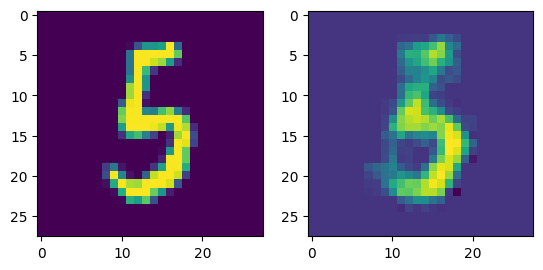

In [203]:
x = img[3,:,:,:]
xt = model(x);
plot_image_pair(x,xt)

In [197]:
z = model.encoder(img[1,:,:,:])

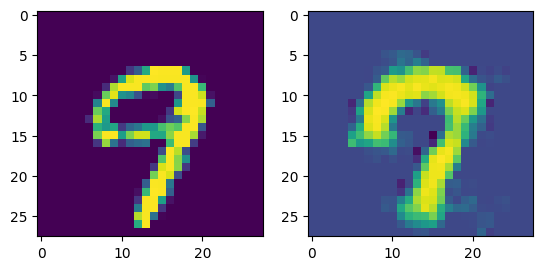

In [200]:
plot_image_pair(x,model.decoder(z+torch.rand_like(z)))

In [212]:
embedding = model.encoder(img[3,:,:,:])  
embedding =  1*embedding + 4*torch.rand_like(embedding)
print(embedding.shape)

torch.Size([8, 2, 2])


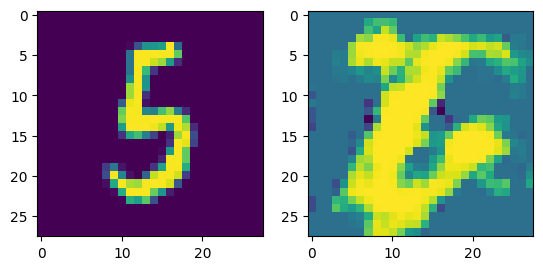

In [213]:
plot_image_pair(x, model.decoder(embedding))

In [173]:
(y==4).nonzero()

tensor([[  0],
        [  9],
        [ 17],
        [ 18],
        [ 21],
        [ 32],
        [ 36],
        [ 75],
        [ 87],
        [103],
        [105],
        [109],
        [111],
        [113],
        [123]])

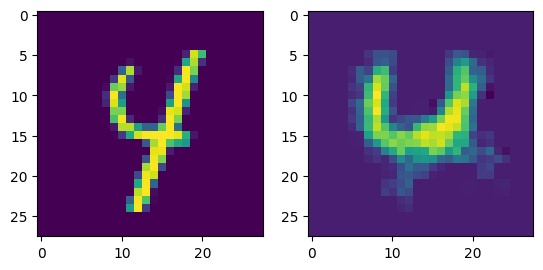

In [182]:
embedding = model.encoder(img[[0,9],:,:,:])
new_emb = embedding.mean(dim=0)
new_emb = new_emb.reshape(1,8,2,2)
plot_image_pair(img[[9],:,:,:], model.decoder(new_emb))

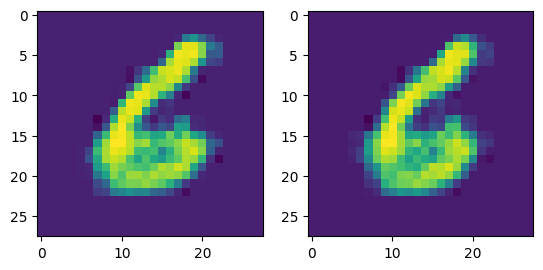

In [140]:
alpha = 0.1
new_seed = ((alpha*embedding[0] + (1-alpha)*embedding[1])).view(1,-1,2,2)
plot_image_pair(model(img[2,:,:,:]), model.decoder(new_seed))